In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import talib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import h5py

import os

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [4]:
## change this path, this is where all your raw data will be saved and retreived afterwards

data_path = 'C:\\Users\Administrator\\Trading_Bot\\data_api_test' 

# Loading the Data Sets from the API:

In [5]:
columns_rename = {'time':'date_time','open':'first','high':'high','low':'low','close':'last','volume':'volume'}

In [6]:
def check_na(df):
    for col in df:
        print("count of NA values in",col,":",str(df[col].isnull().sum()))
        print("\n")

def check_unique(df):
    for col in df:
        print("unique values in",col,":",str(df[col].unique()))
        print("\n")
        
def convert_float(df,col_list):
    for i in col_list:
        df[i] = df[i].astype('float')
        
def read_h5_dataframe(data_path, file_name):
    """
    Reads a pandas dataframe stored in a .h5 file and returns it as a pandas dataframe.
    
    Args:
        data_path (str): The path where the .h5 file is located.
        file_name (str): The name of the .h5 file.
        
    Returns:
        df (pandas.DataFrame): The dataframe read from the .h5 file.
    """
    # Combine the data_path and file_name to form the complete file path.
    file_path = data_path + '/' + file_name
    
    # Read the .h5 file into a pandas dataframe.
    df = pd.read_hdf(file_path, key='df')
    
    return df

def intra_day():
    import pandas as pd
    import requests
    import csv
    # Prompt the user for input
    symbols = input('Enter symbols separated by commas: ').split(',')
    dfs = []
    for symbol in symbols:
        url = 'https://www.alphavantage.co/query'
        params = {
            'function': 'TIME_SERIES_INTRADAY',
            'symbol': symbol,
            'interval': '1min',
            'apikey': 'OX2BPYPUY81XL6PJ',
            'outputsize': 'full',  # Include full historical data
            'start_date': '2022-03-01',  # Set the start date
            'end_date': '2022-03-01'  # Set the end date
        }
        
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            # Convert the data to a DataFrame
            df = pd.DataFrame.from_dict(data['Time Series (1min)'], orient='index')
            df = df.reset_index()
            df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
            df['datetime'] = pd.to_datetime(df['datetime'])
            df = df.sort_values('datetime')
            df['symbol'] = symbol  # Add a new column with the symbol
            df['fwd1min'] = df['close'].shift(-1)  # Add a new column with the 1-minute forward price
            dfs.append(df)
        else:
            print(f'Request failed with status code {response.status_code}')
    data = pd.concat(dfs, ignore_index = True)
    return(data)
    
def api_intra_day_extended(symbol):    
    #print(symbols)
    year = [1, 2]
    months = list(range(1, 13))
    permutations = len(year) * len(months)
    i = 1
    
    dfs = []
    for y in year:
        for m in months:
            print('------------------ progress:' + str(round(i*100/permutations,0)) + '% ------------------')
            i += 1
            url = 'https://www.alphavantage.co/query'
            slice_key = 'year'+str(y)+'month'+str(m)
            params = {
                'function': 'TIME_SERIES_INTRADAY_EXTENDED',
                'symbol': symbol,
                'interval': '1min',
                'apikey': 'TDJCJMSABXYSLRSP', 
                'slice': slice_key
                #'outputsize': 'full',  # Include full historical data
            }
            response = requests.get(url, params=params)
    
            with requests.Session() as s:
                download = s.get(url,params=params)
                decoded_content = download.content.decode('utf-8')
                cr = csv.reader(decoded_content.splitlines(), delimiter=',')
                data = list(cr)
                df = pd.DataFrame(data[1:], columns=data[0])  # Create pandas DataFrame
                #print(slice_key)
                #print(pd.DataFrame(df).head(1))
                #print(pd.DataFrame(df).tail(1))
                #print('\n')
                df['ticker'] = symbol  # Add symbol column to DataFrame
                dfs.append(df)  # Append DataFrame to list of DataFrames
    
    data = pd.concat(dfs)  # Combine list of DataFrames into one DataFrame
    return(data)

def get_save_dataset(symbols, directory):
    for i in symbols:
        print('----------------- ',i,': ----------------- ')
        df = api_intra_day_extended(i)
        
        # Save the DataFrame as an HDF file with the name of the current symbol
        with pd.HDFStore(f'{directory}/{i}.h5', mode='w') as store:
            store.put('df', df)

def retrieve_data(directory, chunksize = 100000):
    """
    Reads all .h5 files in a directory and returns a single dataframe.
    """
    
    dfs_raw = []  # To store dataframes from each file
    
    file_list = [file for file in os.listdir(directory) if file.endswith('.h5')]
    for file in tqdm(file_list, desc='Reading Files'):
        file_path = os.path.join(directory, file)
        with pd.HDFStore(file_path, mode='r') as store:
            dataset_name = list(store.keys())[0]  # Get the name of the dataset
            # Load data from the file into a dataframe
            df = store[dataset_name]
            dfs_raw.append(df)
    
    '''
    
    for file in os.listdir(directory):
        if file.endswith('.h5'):
            file_path = os.path.join(directory, file)
            # Load data from the file into a dataframe in chunks
            for chunk in pd.read_hdf(file_path, key='data', chunksize=chunksize):
                dfs_raw.append(chunk)
    '''
    '''
    for file in os.listdir(directory):
        if file.endswith('.h5'):
            file_path = os.path.join(directory, file)
            # Load data from the file into a dataframe
            df = pd.read_hdf(file_path, key='data')
            dfs_raw.append(df)
    '''
    
    # Concatenate all dataframes into a single dataframe
    data = pd.concat(dfs_raw, ignore_index = True)  # Combine list of DataFrames into one DataFrame
    
            
    ## ADD DATA SANITY CHECKS HERE:
    # Comparison of total days vs. days fetched.
    # Comparison of count before and after dropping NAs. 
        
    data = (data.dropna()
            .rename(columns=columns_rename))
    #data['datetime'] = pd.to_datetime(data['datetime'])
    #data['date'] = data['datetime']
    
    convert_float(data,['first','low','last','volume','high'])
    data = (data.set_index(['date_time'])
            .sort_index()
            .set_index('ticker', append=True)
            .swaplevel())
    data = data.dropna()
    data = data.apply(pd.to_numeric, downcast='integer')
    
    return(data)
    #return(dfs_raw)
    

In [15]:
nasdaq100_1 = ['ABNB','ALGN','AMZN','AMGN','AEP','ADI','ANSS','AAPL','AMAT','ASML','TEAM','ADSK', 'ATVI','ADP','AZN','AVGO','BIIB','BMRN','BKNG','CDNS','CHTR','CPRT','CSGP','CRWD','CTAS','CSCO','CMCSA','COST','CSX','CTSH','DDOG',
             'DXCM','FANG','DLTR','EA','EBAY','ENPH','EXC','FAST','GFS']

nasdaq100_2 = ['META','FISV','FTNT','GILD','GOOG','GOOGL','HON','ILMN','INTC','INTU','ISRG','MRVL','IDXX','JD',
               'KDP','KLAC','KHC','LRCX','LCID','LULU','MELI','MAR','MCHP','MDLZ','MRNA','MNST','MSFT','MU','NFLX']

nasdaq100_3 = ['NVDA','NXPI','ODFL','ORLY','PCAR']

nasdaq100_4 = ['PAYX','PDD','PYPL','PEP','QCOM','REGN','RIVN','ROST','SIRI',
               'SGEN','SBUX','SNPS','TSLA','TXN','TMUS','VRSK','VRTX','WBA','WBD','WDAY','XEL','ZM','ZS','AMD']

               #input('Enter symbols separated by commas: ').split(',')                
               #error: 
nasdaq100_5 =  ['ADBE','PANW','BKR']
                
#save data first
#get_save_dataset(nasdaq100_1,data_path) 

In [9]:
get_save_dataset(nasdaq100_2,data_path)

-----------------  META : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
------------------ progress:75.0% ------------------
---

------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
------------------ progress:75.0% ------------------
------------------ progress:79.0% ------------------
------------------ progress:83.0% ------------------
------------------ progress:88.0% ------------------
------------------ progress:92.0% ------------------
------------------ progress:96.0% ------------------
------------------ progress:100.0% -----------

------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
------------------ progress:75.0% ------------------
------------------ progress:79.0% ------------------
------------------ progress:83.0% ------------------
------------------ progress:88.0% ------------------
------------------ progress:92.0% ------------------
------------------ progress:96.0% ------------------
------------------ progress:100.0% ------------------
-----------------  JD : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
----

------------------ progress:75.0% ------------------
------------------ progress:79.0% ------------------
------------------ progress:83.0% ------------------
------------------ progress:88.0% ------------------
------------------ progress:92.0% ------------------
------------------ progress:96.0% ------------------
------------------ progress:100.0% ------------------
-----------------  LULU : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
--

------------------ progress:100.0% ------------------
-----------------  MNST : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
--

In [10]:
get_save_dataset(nasdaq100_3,data_path)

-----------------  NVDA : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
------------------ progress:75.0% ------------------
---

In [11]:
get_save_dataset(nasdaq100_4,data_path)

-----------------  PAYX : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
------------------ progress:75.0% ------------------
---

------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
------------------ progress:75.0% ------------------
------------------ progress:79.0% ------------------
------------------ progress:83.0% ------------------
------------------ progress:88.0% ------------------
------------------ progress:92.0% ------------------
------------------ progress:96.0% ------------------
------------------ progress:100.0% -----------

------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
------------------ progress:75.0% ------------------
------------------ progress:79.0% ------------------
------------------ progress:83.0% ------------------
------------------ progress:88.0% ------------------
------------------ progress:92.0% ------------------
------------------ progress:96.0% ------------------
------------------ progress:100.0% ------------------
-----------------  TXN : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
---

------------------ progress:75.0% ------------------
------------------ progress:79.0% ------------------
------------------ progress:83.0% ------------------
------------------ progress:88.0% ------------------
------------------ progress:92.0% ------------------
------------------ progress:96.0% ------------------
------------------ progress:100.0% ------------------
-----------------  WDAY : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
--

In [16]:
get_save_dataset(nasdaq100_5,data_path)

-----------------  ADBE : ----------------- 
------------------ progress:4.0% ------------------
------------------ progress:8.0% ------------------
------------------ progress:12.0% ------------------
------------------ progress:17.0% ------------------
------------------ progress:21.0% ------------------
------------------ progress:25.0% ------------------
------------------ progress:29.0% ------------------
------------------ progress:33.0% ------------------
------------------ progress:38.0% ------------------
------------------ progress:42.0% ------------------
------------------ progress:46.0% ------------------
------------------ progress:50.0% ------------------
------------------ progress:54.0% ------------------
------------------ progress:58.0% ------------------
------------------ progress:62.0% ------------------
------------------ progress:67.0% ------------------
------------------ progress:71.0% ------------------
------------------ progress:75.0% ------------------
---

In [17]:
df = retrieve_data(data_path)

Reading Files: 100%|█████████████████████████████████████████████████████████████████| 102/102 [07:49<00:00,  4.60s/it]


In [18]:
df.head()

,,first,high,low,last,volume
ticker,date_time,,,,,
AAPL,2021-05-10 04:01:00,128.652351,128.721636,128.652351,128.721636,2606
CSCO,2021-05-10 04:01:00,50.312278,50.312278,50.312278,50.312278,174
QCOM,2021-05-10 04:01:00,130.895964,130.895964,130.598277,130.598277,561
JD,2021-05-10 04:01:00,71.184868,71.232966,71.184868,71.184868,4418
INTC,2021-05-10 04:01:00,53.765181,53.840168,53.765181,53.840168,3155


In [19]:
df.info()
## issue: returning only 1 years data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21158668 entries, ('AAPL', '2021-05-10 04:01:00') to ('AAPL', '2023-04-28 20:00:00')
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   first   float64
 1   high    float64
 2   low     float64
 3   last    float64
 4   volume  int32  
dtypes: float64(4), int32(1)
memory usage: 847.1+ MB


In [20]:
df = df.reset_index()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date.astype('datetime64[ns]')
df = (df.set_index(['date_time'])
           .sort_index()
           .set_index('ticker', append=True)
           .swaplevel())

# Feature Engineering

In [21]:
by_ticker = df.sort_index().groupby('ticker', group_keys=False)
by_ticker_date = df.sort_index().groupby(['ticker', 'date'])

In [22]:
data = pd.DataFrame(index=df.index)

In [23]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [24]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('date_time').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

In [25]:
data[f'ret1min'] = df['last'].div(df['first']).sub(1)

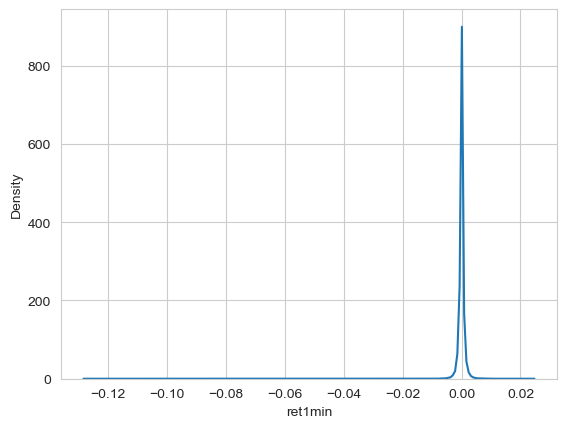

In [26]:
sns.kdeplot(data.ret1min.sample(n=100000));

In [28]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

,,date,minute,ret1min,first,last
ticker,date_time,,,,,
ILMN,2022-08-11 16:58:00,317,777,0.271396,178.890000,227.440000
ATVI,2022-01-18 08:17:00,175,256,0.232404,64.546475,79.547342
PDD,2022-03-21 08:11:00,218,250,0.177179,38.210000,44.980000
JD,2022-03-16 04:01:00,215,0,0.116334,49.117559,54.831587
RIVN,2022-09-08 09:01:00,336,300,0.113870,33.020000,36.780000
PDD,2022-03-16 04:01:00,215,0,0.112534,29.680000,33.020000
JD,2022-04-29 04:01:00,246,0,0.109272,58.102243,64.451164
AMZN,2022-02-03 16:02:00,187,721,0.102740,139.250000,153.556500
ATVI,2022-01-18 08:18:00,175,257,0.098765,80.521553,88.474299


## Lagged Returns

In [29]:
for t in tqdm(range(2, 11)):
    data[f'ret{t}min'] = df['last'].div(by_ticker_date['first'].shift(t-1)).sub(1)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [43:53<00:00, 292.59s/it]


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21158668 entries, ('AAPL', Timestamp('2021-05-10 04:01:00')) to ('AAPL', Timestamp('2023-04-28 20:00:00'))
Data columns (total 12 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      int64  
 1   minute    int32  
 2   ret1min   float64
 3   ret2min   float64
 4   ret3min   float64
 5   ret4min   float64
 6   ret5min   float64
 7   ret6min   float64
 8   ret7min   float64
 9   ret8min   float64
 10  ret9min   float64
 11  ret10min  float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 2.4+ GB


<Axes: xlabel='ret1min', ylabel='Density'>

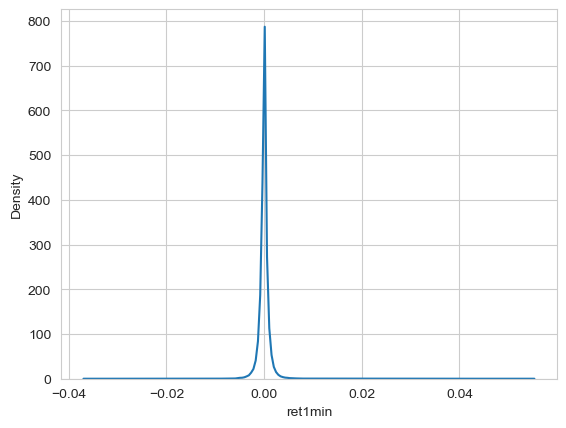

In [31]:
sns.kdeplot(data.ret1min.sample(n=100000))

In [32]:
data.ret1min.describe(percentiles=np.arange(.1, 1, .1)).iloc[1:].apply(lambda x: f'{x:.3%}')

mean     -0.000%
std       0.113%
min     -16.459%
10%      -0.091%
20%      -0.047%
30%      -0.023%
40%      -0.006%
50%       0.000%
60%       0.006%
70%       0.023%
80%       0.046%
90%       0.090%
max      27.140%
Name: ret1min, dtype: object

In [33]:
print(f'Skew: {data.ret1min.skew():.2f} | Kurtosis: {data.ret1min.kurtosis():.2f}')

Skew: 0.60 | Kurtosis: 609.67


In [34]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

,,date,minute,ret1min,ret2min,ret3min,ret4min,ret5min,ret6min,ret7min,ret8min,ret9min,ret10min,first,last
ticker,date_time,,,,,,,,,,,,,,
ILMN,2022-08-11 16:58:00,317,777,0.271396,0.269126,0.272036,0.270676,0.273740,0.273746,0.279550,0.290440,0.290440,0.290440,178.890000,227.440000
ATVI,2022-01-18 08:17:00,175,256,0.232404,0.241583,0.231456,0.231456,0.244284,0.242547,0.241390,0.244479,0.245060,0.245254,64.546475,79.547342
PDD,2022-03-21 08:11:00,218,250,0.177179,0.000445,-0.004867,-0.006186,0.004242,0.009425,0.009652,0.097073,-0.004204,0.009652,38.210000,44.980000
JD,2022-03-16 04:01:00,215,0,0.116334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.117559,54.831587
RIVN,2022-09-08 09:01:00,336,300,0.113870,0.113870,0.113870,0.113870,0.112523,0.111850,0.107838,0.107871,0.113533,0.112523,33.020000,36.780000
PDD,2022-03-16 04:01:00,215,0,0.112534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.680000,33.020000
JD,2022-04-29 04:01:00,246,0,0.109272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.102243,64.451164
AMZN,2022-02-03 16:02:00,187,721,0.102740,0.105952,0.103195,0.102498,0.101735,0.100089,0.104147,0.104981,0.103639,0.104024,139.250000,153.556500
ATVI,2022-01-18 08:18:00,175,257,0.098765,0.370707,0.380915,0.369652,0.369652,0.383919,0.381988,0.380701,0.384137,0.384783,80.521553,88.474299


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21158668 entries, ('AAPL', Timestamp('2021-05-10 04:01:00')) to ('AAPL', Timestamp('2023-04-28 20:00:00'))
Data columns (total 12 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      int64  
 1   minute    int32  
 2   ret1min   float64
 3   ret2min   float64
 4   ret3min   float64
 5   ret4min   float64
 6   ret5min   float64
 7   ret6min   float64
 8   ret7min   float64
 9   ret8min   float64
 10  ret9min   float64
 11  ret10min  float64
dtypes: float64(10), int32(1), int64(1)
memory usage: 2.4+ GB


## Forward Returns

In [36]:
data['fwd1min'] = (data
                   .sort_index()
                   .groupby(['ticker', 'date'])
                   .ret1min
                   .shift(-1))

In [37]:
data = data.dropna(subset=['fwd1min'])

In [38]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21109132 entries, ('AAPL', Timestamp('2021-05-10 04:01:00')) to ('NFLX', Timestamp('2023-04-28 19:59:00'))
Data columns (total 13 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   date      21109132 non-null  int64  
 1   minute    21109132 non-null  int32  
 2   ret1min   21109132 non-null  float64
 3   ret2min   21059596 non-null  float64
 4   ret3min   21010060 non-null  float64
 5   ret4min   20960524 non-null  float64
 6   ret5min   20910988 non-null  float64
 7   ret6min   20861452 non-null  float64
 8   ret7min   20811916 non-null  float64
 9   ret8min   20762380 non-null  float64
 10  ret9min   20712844 non-null  float64
 11  ret10min  20663308 non-null  float64
 12  fwd1min   21109132 non-null  float64
dtypes: float64(11), int32(1), int64(1)
memory usage: 2.1+ GB


## Other Technical Features:

In [39]:
data['BOP'] = (by_ticker.apply(lambda x: talib.BOP(x['first'],
                                                   x.high,
                                                   x.low,
                                                   x['last'])))

In [40]:
data['CCI'] = (by_ticker.apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x['last'],
                                          timeperiod=14)))

In [41]:
data['MFI'] = (by_ticker.apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x['last'],
                                          x.volume,
                                          timeperiod=14)))

In [42]:
data[['BOP', 'CCI', 'MFI']].describe(deciles)

,BOP,CCI,MFI
count,2.110913e+07,2.110782e+07,2.110772e+07
mean,-3.050213e-03,7.273535e-01,5.019216e+01
std,6.422639e-01,1.084484e+02,1.904851e+01
min,-1.000000e+00,-4.666667e+02,-1.185629e-08
10%,-9.705882e-01,-1.372988e+02,2.506631e+01
20%,-6.785714e-01,-9.987350e+01,3.335934e+01
30%,-4.287500e-01,-6.913580e+01,3.961832e+01
40%,-1.250000e-01,-3.654147e+01,4.507982e+01
50%,0.000000e+00,1.559020e+00,5.022942e+01
60%,1.111765e-01,3.903656e+01,5.536718e+01


In [43]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x['last'].ffill(),
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

In [44]:
def compute_stoch(x, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high.ffill(), x.low.ffill(), x['last'].ffill(), 
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)
    return pd.DataFrame({'slowd': slowd, 
                         'slowk': slowk}, 
                        index=x.index)

In [45]:
data = data.join(by_ticker.apply(compute_stoch))

In [46]:
data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high.ffill(), 
                                                    x.low.ffill(), 
                                                    x['last'].ffill()))

In [47]:
del df

In [48]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21109132 entries, ('AAPL', Timestamp('2021-05-10 04:01:00')) to ('NFLX', Timestamp('2023-04-28 19:59:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   date      21109132 non-null  int64  
 1   minute    21109132 non-null  int32  
 2   ret1min   21109132 non-null  float64
 3   ret2min   21059596 non-null  float64
 4   ret3min   21010060 non-null  float64
 5   ret4min   20960524 non-null  float64
 6   ret5min   20910988 non-null  float64
 7   ret6min   20861452 non-null  float64
 8   ret7min   20811916 non-null  float64
 9   ret8min   20762380 non-null  float64
 10  ret9min   20712844 non-null  float64
 11  ret10min  20663308 non-null  float64
 12  fwd1min   21109132 non-null  float64
 13  BOP       21109132 non-null  float64
 14  CCI       21107819 non-null  float64
 15  MFI       21107718 non-null  float64
 16  STOCHRSI  21106203 non-null  float64
 17  slowd  

# Evaluate features

In [49]:
features = ['ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min', 
            'ret6min', 'ret7min', 'ret8min', 'ret9min', 'ret10min','BOP', 'CCI', 'MFI', 'STOCHRSI', 
            'slowk', 'slowd']

In [50]:
sample = data.sample(n=100000)

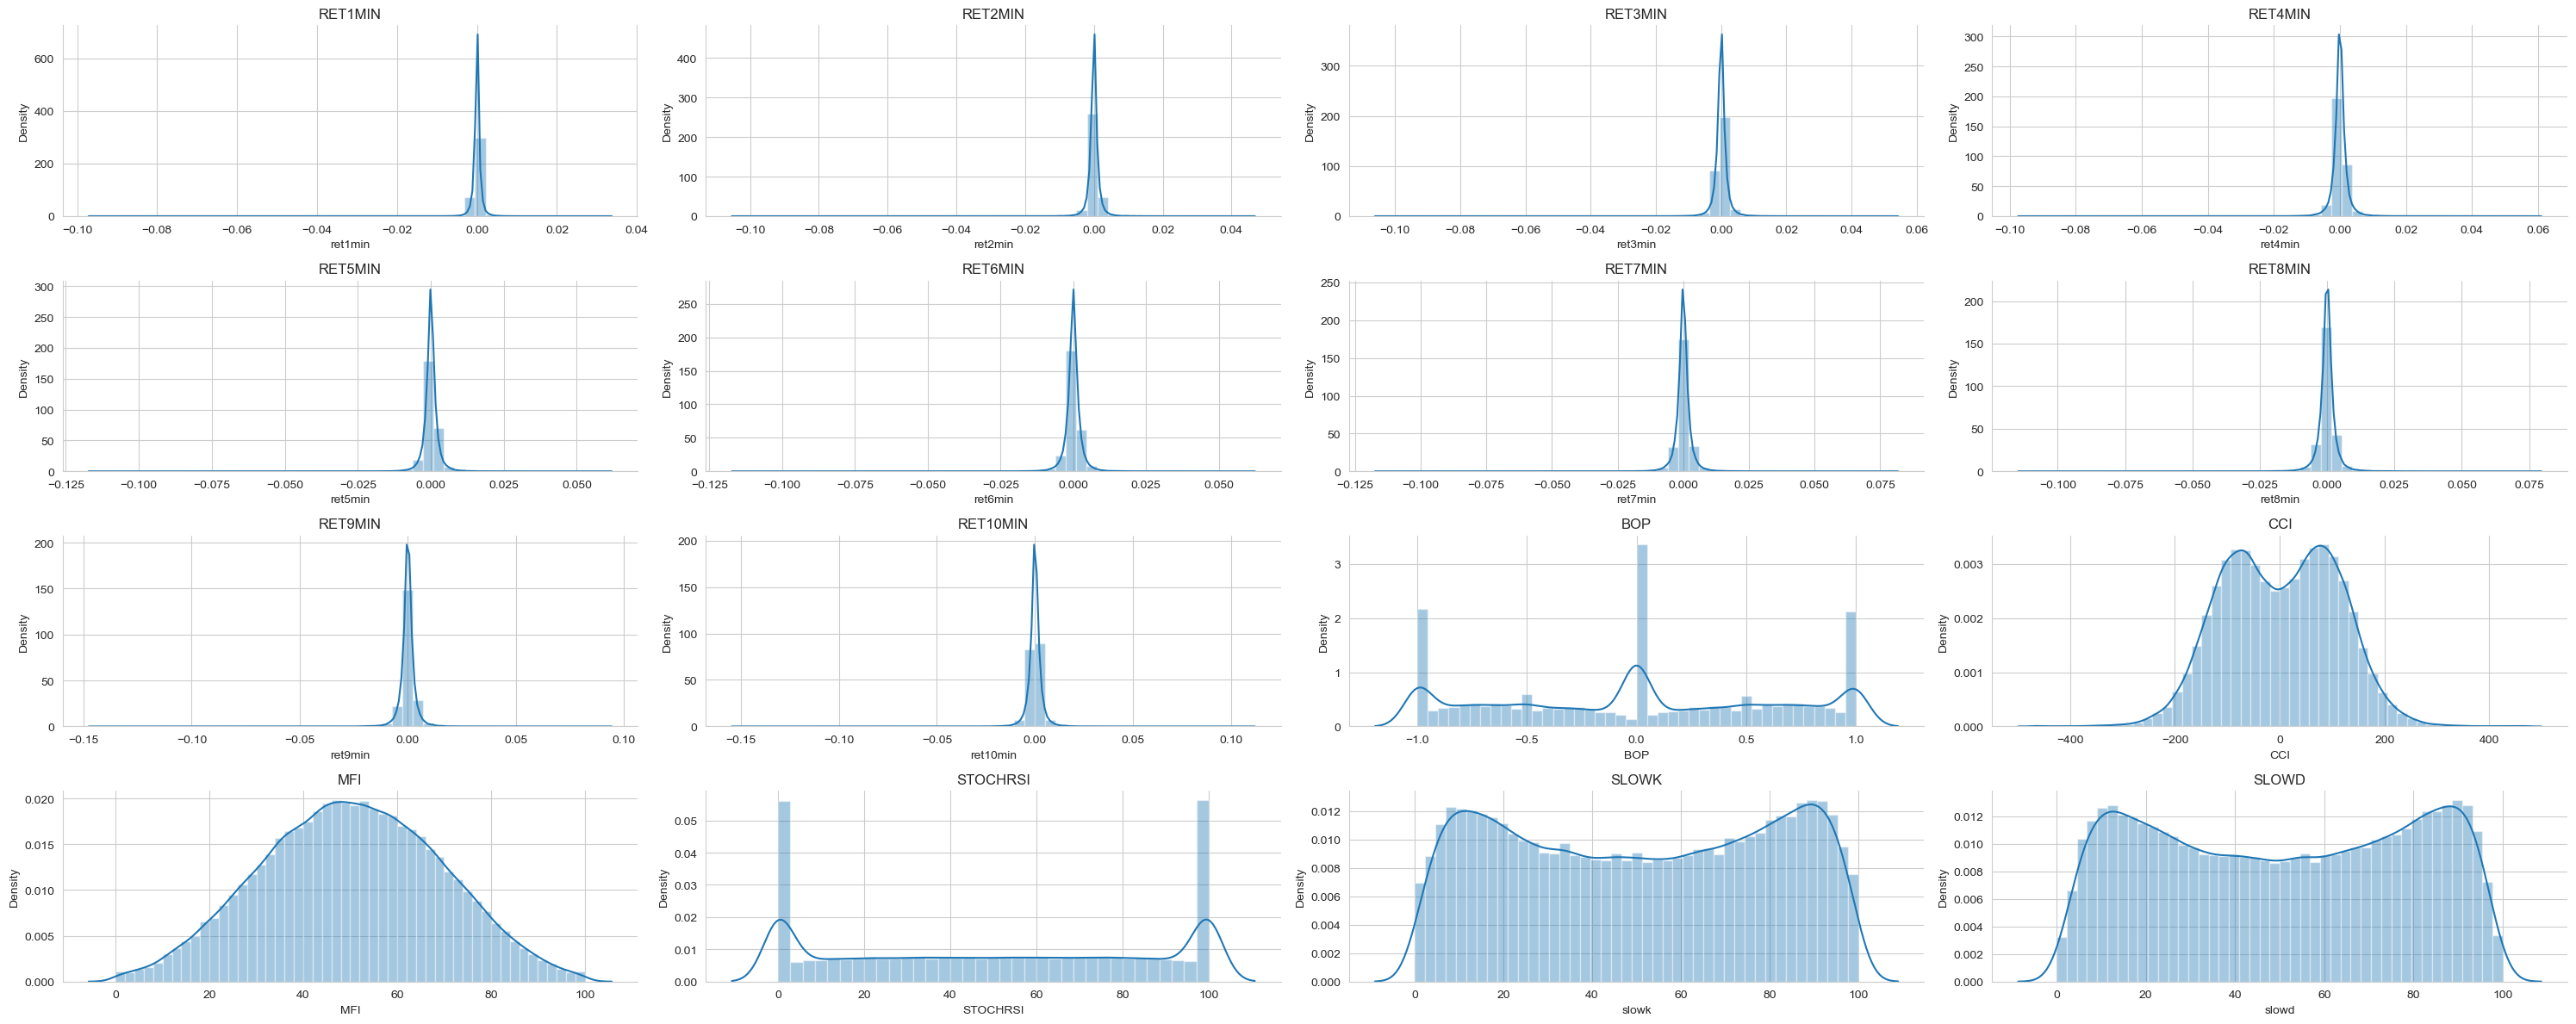

In [51]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(30, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.distplot(sample[feature], ax=axes[i])
    axes[i].set_title(feature.upper())
    
sns.despine()
fig.tight_layout()

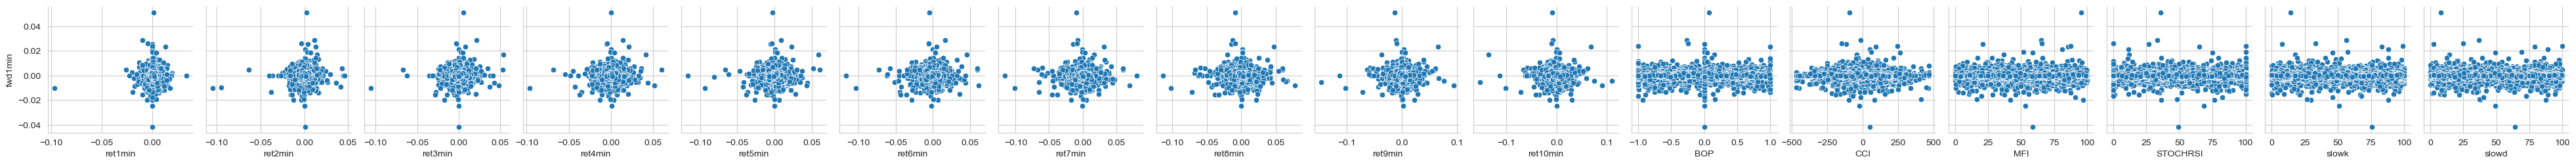

In [52]:
sns.pairplot(sample, y_vars=['fwd1min'], x_vars=features);

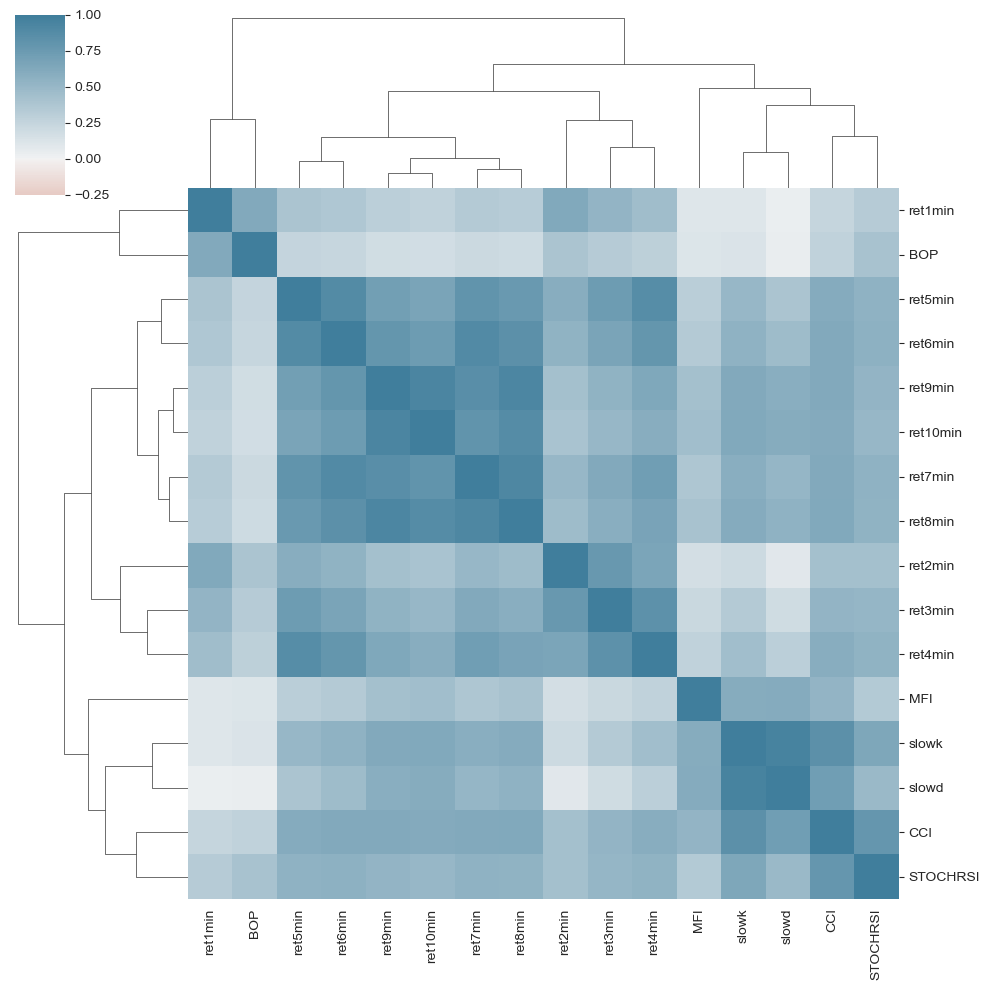

In [53]:
corr = sample.loc[:, features].corr()
sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0, vmin=-.25);

In [54]:
ic = {}
for feature in tqdm(features):
    df = data[['fwd1min', feature]].dropna()
    by_day = df.groupby(df.index.get_level_values('date_time').date) # calc per min is very time-consuming
    ic[feature] = by_day.apply(lambda x: spearmanr(x.fwd1min, x[feature])[0]).mean()
ic = pd.Series(ic)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [04:01<00:00, 15.06s/it]


In [55]:
ic.sort_values()

ret3min    -0.007558
ret2min    -0.007341
CCI        -0.007000
STOCHRSI   -0.006903
ret9min    -0.006871
ret4min    -0.006603
ret8min    -0.006557
ret10min   -0.006426
ret7min    -0.006287
ret6min    -0.005832
ret5min    -0.005292
ret1min    -0.005057
slowk      -0.004542
BOP        -0.003682
MFI        -0.003105
slowd      -0.003035
dtype: float64

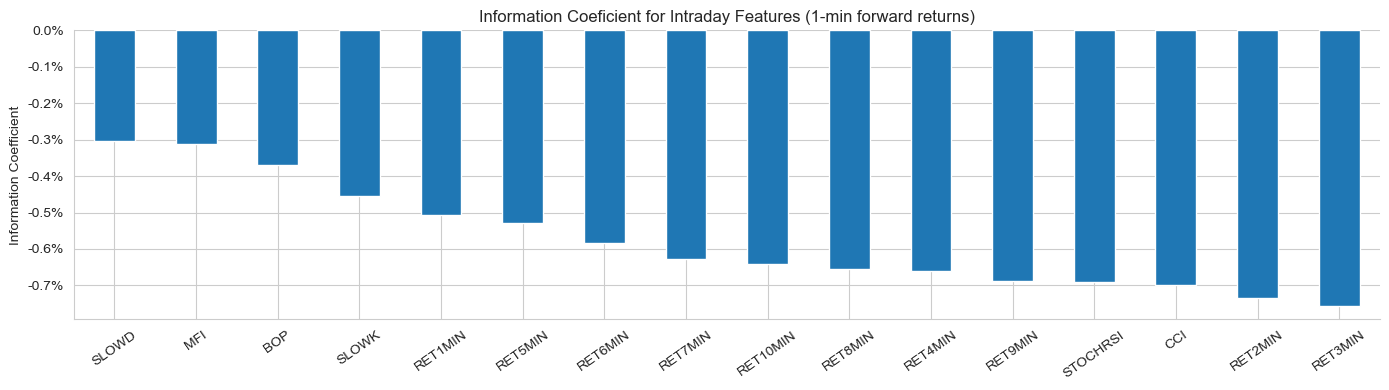

In [56]:
title = 'Information Coeficient for Intraday Features (1-min forward returns)'
ic.index = ic.index.map(str.upper)
ax = ic.sort_values(ascending=False).plot.bar(figsize=(14, 4), title=title, rot=35)
ax.set_ylabel('Information Coefficient')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
sns.despine()
plt.tight_layout();

In [57]:
data.info(null_counts=True)

## main code has 5 more extra columns: up, down, rup, rdown, trade_bid_ask. We cant have those because of data constraints

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21109132 entries, ('AAPL', Timestamp('2021-05-10 04:01:00')) to ('NFLX', Timestamp('2023-04-28 19:59:00'))
Data columns (total 20 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   date      21109132 non-null  int64  
 1   minute    21109132 non-null  int32  
 2   ret1min   21109132 non-null  float64
 3   ret2min   21059596 non-null  float64
 4   ret3min   21010060 non-null  float64
 5   ret4min   20960524 non-null  float64
 6   ret5min   20910988 non-null  float64
 7   ret6min   20861452 non-null  float64
 8   ret7min   20811916 non-null  float64
 9   ret8min   20762380 non-null  float64
 10  ret9min   20712844 non-null  float64
 11  ret10min  20663308 non-null  float64
 12  fwd1min   21109132 non-null  float64
 13  BOP       21109132 non-null  float64
 14  CCI       21107819 non-null  float64
 15  MFI       21107718 non-null  float64
 16  STOCHRSI  21106203 non-null  float64
 17  slowd  

In [58]:
data = data.drop(['date'], axis=1)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21109132 entries, ('AAPL', Timestamp('2021-05-10 04:01:00')) to ('NFLX', Timestamp('2023-04-28 19:59:00'))
Data columns (total 19 columns):
 #   Column    Dtype  
---  ------    -----  
 0   minute    int32  
 1   ret1min   float64
 2   ret2min   float64
 3   ret3min   float64
 4   ret4min   float64
 5   ret5min   float64
 6   ret6min   float64
 7   ret7min   float64
 8   ret8min   float64
 9   ret9min   float64
 10  ret10min  float64
 11  fwd1min   float64
 12  BOP       float64
 13  CCI       float64
 14  MFI       float64
 15  STOCHRSI  float64
 16  slowd     float64
 17  slowk     float64
 18  NATR      float64
dtypes: float64(18), int32(1)
memory usage: 3.5+ GB


# Import and Settings

In [61]:
%matplotlib inline

import sys, os
from pathlib import Path
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [62]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

ModuleNotFoundError: No module named 'utils'

In [63]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [64]:
# where we'll store the model results
result_store = 'C:\\Users\Administrator\\Trading_Bot\\data\\intra_day.h5'

In [65]:
# here we save the trained models
model_path = Path('C:\\Users\Administrator\\Trading_Bot\\models\\intraday')
if not model_path.exists():
    model_path.mkdir(parents=True)

In [66]:
import numpy as np

np.random.seed(42)

def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'


class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [67]:
data.sample(frac=.1).describe(percentiles=np.arange(.1, 1, .1))

,minute,ret1min,ret2min,ret3min,ret4min,ret5min,ret6min,ret7min,ret8min,ret9min,ret10min,fwd1min,BOP,CCI,MFI,STOCHRSI,slowd,slowk,NATR
count,2.110913e+06,2.110913e+06,2.105807e+06,2.100813e+06,2.095787e+06,2.090769e+06,2.085947e+06,2.081019e+06,2.076050e+06,2.071116e+06,2.066130e+06,2.110913e+06,2.110913e+06,2.110793e+06,2.110784e+06,2.110638e+06,2.110756e+06,2.110756e+06,2.110784e+06
mean,5.183546e+02,-2.959332e-06,-3.259880e-06,-9.215014e-07,-1.599143e-06,-7.347598e-07,-1.224481e-06,1.043831e-07,1.469924e-06,2.192504e-06,8.818537e-07,-2.095042e-06,-2.714845e-03,7.016398e-01,5.020469e+01,5.014131e+01,5.038434e+01,5.037586e+01,1.227674e-01
std,1.530732e+02,1.137771e-03,1.735748e-03,2.150631e-03,2.453313e-03,2.727368e-03,2.965297e-03,3.188374e-03,3.389353e-03,3.582224e-03,3.779387e-03,1.136535e-03,6.421344e-01,1.084506e+02,1.904078e+01,3.580252e+01,2.877956e+01,2.968406e+01,9.936820e-02
min,0.000000e+00,-1.025012e-01,-1.264398e-01,-1.743368e-01,-1.788486e-01,-1.833333e-01,-3.117978e-01,-2.772861e-01,-2.343750e-01,-2.324561e-01,-2.034331e-01,-1.368078e-01,-1.000000e+00,-4.666667e+02,-8.653991e-10,0.000000e+00,-4.850046e-12,-3.993842e-12,4.579669e-03
10%,3.430000e+02,-9.130752e-04,-1.447840e-03,-1.794920e-03,-2.092727e-03,-2.351969e-03,-2.577644e-03,-2.783966e-03,-2.976996e-03,-3.158814e-03,-3.328826e-03,-9.111703e-04,-9.696970e-01,-1.373455e+02,2.509344e+01,0.000000e+00,1.121367e+01,1.000000e+01,4.409230e-02
20%,3.870000e+02,-4.748839e-04,-7.901045e-04,-9.888662e-04,-1.153698e-03,-1.296490e-03,-1.427181e-03,-1.542561e-03,-1.643914e-03,-1.746217e-03,-1.844774e-03,-4.723170e-04,-6.785714e-01,-9.990425e+01,3.339982e+01,9.172138e+00,1.944444e+01,1.839715e+01,5.645870e-02
30%,4.310000e+02,-2.352839e-04,-4.374188e-04,-5.546827e-04,-6.496670e-04,-7.287418e-04,-8.014112e-04,-8.645533e-04,-9.253715e-04,-9.841153e-04,-1.038773e-03,-2.342743e-04,-4.285714e-01,-6.918521e+01,3.963979e+01,2.316877e+01,2.879014e+01,2.807003e+01,6.814384e-02
40%,4.750000e+02,-6.197323e-05,-1.858506e-04,-2.433924e-04,-2.853651e-04,-3.229624e-04,-3.552833e-04,-3.852080e-04,-4.148230e-04,-4.390965e-04,-4.644705e-04,-6.195019e-05,-1.250000e-01,-3.655275e+01,4.508071e+01,3.669389e+01,3.931664e+01,3.888889e+01,8.051459e-02
50%,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.519388e+00,5.021891e+01,5.026373e+01,5.054593e+01,5.050505e+01,9.474499e-02
60%,5.660000e+02,5.841838e-05,1.838911e-04,2.444963e-04,2.894356e-04,3.297214e-04,3.639893e-04,3.973038e-04,4.272287e-04,4.563085e-04,4.818869e-04,5.798446e-05,1.121495e-01,3.905816e+01,5.537532e+01,6.378038e+01,6.177106e+01,6.214815e+01,1.121863e-01


# Model Tuning

## Helper Functions

In [68]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [69]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [70]:
data['stock_id'] = pd.factorize(data.index.get_level_values('ticker'), sort=True)[0]

In [71]:
categoricals = ['stock_id']

In [72]:
categoricals

['stock_id']

In [73]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

In [74]:
DAY = 390   # number of minute bars in a trading day of 6.5 hrs (9:30 - 15:59)
MONTH = 21  # trading days

In [76]:
def get_cv(n_splits=23):
    return MultipleTimeSeriesCV(n_splits=n_splits,
                                lookahead=1,
                                test_period_length=MONTH * DAY,       # test for 1 month
                                train_period_length=12 * MONTH * DAY,  # train for 1 year
                                date_idx='date_time')

In [77]:
for i, (train_idx, test_idx) in enumerate(get_cv().split(X=data)):
    train_dates = data.iloc[train_idx].index.unique('date_time')
    test_dates = data.iloc[test_idx].index.unique('date_time')
    print(train_dates.min(), train_dates.max(), test_dates.min(), test_dates.max())

2022-11-16 12:23:00 2023-04-18 11:15:00 2023-04-18 11:16:00 2023-04-28 19:59:00
2022-11-03 19:41:00 2023-04-04 18:24:00 2023-04-04 18:25:00 2023-04-18 11:15:00
2022-10-24 10:59:00 2023-03-23 09:36:00 2023-03-23 09:37:00 2023-04-04 18:24:00
2022-10-11 18:04:00 2023-03-10 16:54:00 2023-03-10 16:55:00 2023-03-23 09:36:00
2022-09-29 09:04:00 2023-02-28 08:14:00 2023-02-28 08:15:00 2023-03-10 16:54:00
2022-09-16 16:06:00 2023-02-14 15:33:00 2023-02-14 15:34:00 2023-02-28 08:14:00
2022-09-06 06:57:00 2023-02-02 06:54:00 2023-02-02 06:55:00 2023-02-14 15:33:00
2022-08-23 13:41:00 2023-01-20 14:13:00 2023-01-20 14:14:00 2023-02-02 06:54:00
2022-08-11 04:34:00 2023-01-09 05:32:00 2023-01-09 05:33:00 2023-01-20 14:13:00
2022-07-29 11:31:00 2022-12-23 12:53:00 2022-12-23 12:54:00 2023-01-09 05:32:00
2022-07-18 18:36:00 2022-12-13 04:07:00 2022-12-13 04:08:00 2022-12-23 12:53:00
2022-07-06 09:01:00 2022-11-30 11:11:00 2022-11-30 11:12:00 2022-12-13 04:07:00
2022-06-22 15:43:00 2022-11-16 12:22:00 

In [85]:
label = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(label).tolist()
label = label[0]
print(label)
print(features)

fwd1min
['BOP', 'CCI', 'MFI', 'NATR', 'STOCHRSI', 'minute', 'ret10min', 'ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min', 'ret6min', 'ret7min', 'ret8min', 'ret9min', 'slowd', 'slowk', 'stock_id']


In [90]:
params = dict(objective='regression',
              metric=['rmse'],
              device='cpu',
              max_bin=63,
              gpu_use_dp=False,
              num_leaves=16,
              min_data_in_leaf=500,
              feature_fraction=.8,
              verbose=-1)

In [91]:
num_boost_round = 250

In [92]:
cv = get_cv(n_splits=23) # we have enough data for 23 different test periods

In [93]:
def get_scores(result):
    return pd.DataFrame({'train': result['training']['ic'],
                         'valid': result['valid_1']['ic']})

In [94]:
start = time()
for fold, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
    # create lgb train set
    train_set = data.iloc[train_idx, :]
    lgb_train = lgb.Dataset(data=train_set.drop(label, axis=1),
                            label=train_set[label],
                            categorical_feature=categoricals)
    
    # create lgb test set
    test_set = data.iloc[test_idx, :]
    lgb_test = lgb.Dataset(data=test_set.drop(label, axis=1),
                           label=test_set[label],
                           categorical_feature=categoricals, 
                           reference=lgb_train)

    # train model
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_test],
                      feval=ic_lgbm,
                      num_boost_round=num_boost_round,
                      evals_result=evals_result,
                      verbose_eval=50)
    model.save_model((model_path / f'{fold:02}.txt').as_posix())
    
    # get train/valid ic scores
    scores = get_scores(evals_result)
    scores.to_hdf(result_store, f'ic/{fold:02}')
    
    # get feature importance
    fi = get_fi(model)
    fi.to_hdf(result_store, f'fi/{fold:02}')
    
    # generate validation predictions
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, [label]]
    y_test['pred'] = model.predict(X_test)
    y_test.to_hdf(result_store, f'predictions/{fold:02}')
    
    # compute average IC per minute
    by_minute = y_test.groupby(test_set.index.get_level_values('date_time'))
    daily_ic = by_minute.apply(lambda x: spearmanr(x[label], x.pred)[0]).mean()
    print(f'\nFold: {fold:02} | {format_time(time()-start)} | IC per minute: {daily_ic:.2%}\n')

[50]	training's rmse: 0.00103595	training's ic: 0.0263858	valid_1's rmse: 0.00097094	valid_1's ic: 0.00655552
[100]	training's rmse: 0.00103458	training's ic: 0.0330867	valid_1's rmse: 0.000971003	valid_1's ic: 0.00801068
[150]	training's rmse: 0.00103333	training's ic: 0.0372906	valid_1's rmse: 0.000971268	valid_1's ic: 0.00943595
[200]	training's rmse: 0.00103224	training's ic: 0.0414134	valid_1's rmse: 0.000971409	valid_1's ic: 0.0104225
[250]	training's rmse: 0.00103134	training's ic: 0.0461941	valid_1's rmse: 0.000971377	valid_1's ic: 0.0118899

Fold: 01 | 00:12:22 | IC per minute: 1.66%

[50]	training's rmse: 0.00107865	training's ic: 0.0249957	valid_1's rmse: 0.000791158	valid_1's ic: 0.0160426
[100]	training's rmse: 0.00107716	training's ic: 0.0318079	valid_1's rmse: 0.000791123	valid_1's ic: 0.0170175
[150]	training's rmse: 0.00107602	training's ic: 0.0368988	valid_1's rmse: 0.000791131	valid_1's ic: 0.0179069
[200]	training's rmse: 0.00107493	training's ic: 0.0409977	valid_1'

[250]	training's rmse: 0.00117018	training's ic: 0.0528705	valid_1's rmse: 0.00131834	valid_1's ic: 0.00403171

Fold: 14 | 02:54:34 | IC per minute: 0.85%

[50]	training's rmse: 0.00114831	training's ic: 0.0344767	valid_1's rmse: 0.00144801	valid_1's ic: 0.00960114
[100]	training's rmse: 0.00114655	training's ic: 0.0420081	valid_1's rmse: 0.00144899	valid_1's ic: 0.0132446
[150]	training's rmse: 0.00114509	training's ic: 0.0477181	valid_1's rmse: 0.0014497	valid_1's ic: 0.0134288
[200]	training's rmse: 0.0011439	training's ic: 0.0516304	valid_1's rmse: 0.00145052	valid_1's ic: 0.0128595
[250]	training's rmse: 0.00114277	training's ic: 0.0552027	valid_1's rmse: 0.00145127	valid_1's ic: 0.0117521

Fold: 15 | 03:07:50 | IC per minute: 0.78%

[50]	training's rmse: 0.00116446	training's ic: 0.0322051	valid_1's rmse: 0.00133012	valid_1's ic: 0.0147621
[100]	training's rmse: 0.00116267	training's ic: 0.0386683	valid_1's rmse: 0.00133047	valid_1's ic: 0.0159883
[150]	training's rmse: 0.0011611

## Signal Evaluation

In [95]:
with pd.HDFStore(result_store) as store:
    pred_keys = [k[1:] for k in store.keys() if k[1:].startswith('pred')]
    cv_predictions = pd.concat([store[k] for k in pred_keys]).sort_index()

In [96]:
cv_predictions.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8646522 entries, ('AAPL', Timestamp('2022-07-18 18:36:00')) to ('ZS', Timestamp('2023-04-28 19:04:00'))
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   fwd1min  8646522 non-null  float64
 1   pred     8646522 non-null  float64
dtypes: float64(2)
memory usage: 178.6+ MB


In [122]:
time_stamp = cv_predictions.index.get_level_values('date_time')
dates = sorted(np.unique(time_stamp.date))

In [123]:
print(f'# Days: {len(dates)} | First: {dates[0]} | Last: {dates[-1]}')

# Days: 197 | First: 2022-07-19 | Last: 2023-04-28


In [124]:
n = cv_predictions.groupby('date_time').size()

In [125]:
n

date_time
2022-07-19 09:31:00    101
2022-07-19 09:32:00     97
2022-07-19 09:33:00     98
2022-07-19 09:34:00     98
2022-07-19 09:35:00    101
                      ... 
2023-04-28 15:57:00    101
2023-04-28 15:58:00    101
2023-04-28 15:59:00    101
2023-04-28 16:00:00    101
2023-04-28 16:01:00     90
Length: 76138, dtype: int64

In [171]:
## Change hardcoded below number 12 to the number of stocks you have in your data set.

incomplete_minutes = n[n<92].index

In [172]:
print(f'{len(incomplete_minutes)} ({len(incomplete_minutes)/len(n):.2%})')

1867 (2.45%)


In [173]:
cv_predictions = cv_predictions[~time_stamp.isin(incomplete_minutes)]

In [174]:
cv_predictions.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7247209 entries, ('AAPL', Timestamp('2022-07-19 09:31:00')) to ('ZS', Timestamp('2023-04-28 16:00:00'))
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   fwd1min   7247209 non-null  float64
 1   pred      7247209 non-null  float64
 2   quintile  7247209 non-null  int32  
 3   decile    7247209 non-null  int32  
dtypes: float64(2), int32(2)
memory usage: 205.9+ MB


## Information Coefficients

### Accross all periods

In [175]:
ic = spearmanr(cv_predictions.fwd1min, cv_predictions.pred)[0]

### By minute

In [176]:
minutes = cv_predictions.index.get_level_values('date_time')
by_minute = cv_predictions.groupby(minutes)

In [177]:
ic_by_minute = by_minute.apply(lambda x: spearmanr(x.fwd1min, x.pred)[0])

minute_ic_mean = ic_by_minute.mean()
minute_ic_median = ic_by_minute.median()

#print(f'\nAll periods: {ic:6.2%} | By Minute: {minute_ic_mean: 6.2%} (Median: {minute_ic_median: 6.2%})')

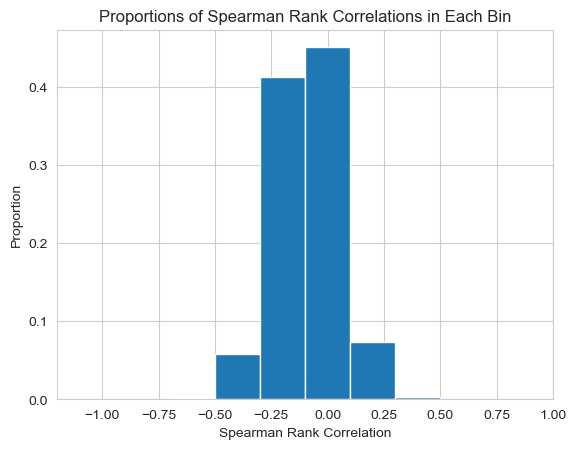

In [178]:
ic_by_minute_df = ic_by_minute.to_frame(name='spearman_corr')

# Define the edges of the bins
bin_edges = np.arange(-1.0, 1.2, 0.2)

# Compute the histogram of the correlations
hist, _ = np.histogram(ic_by_minute_df['spearman_corr'], bins=bin_edges)

# Compute the proportion of each bin in the whole dataset
proportions = hist / len(ic_by_minute_df)

# Plot the proportions for each bin
plt.bar(bin_edges[:-1], proportions, width=0.2)
plt.title('Proportions of Spearman Rank Correlations in Each Bin')
plt.xlabel('Spearman Rank Correlation')
plt.ylabel('Proportion')
plt.show()

In [179]:
print(f'All Periods: {round(ic*100,2)}%')
print(f'By Minute Mean: {round(minute_ic_mean*100,2)}%')
print(f'By Minute Median: {round(minute_ic_median*100,2)}%')

All Periods: 0.64%
By Minute Mean: 0.85%
By Minute Median: 0.91%


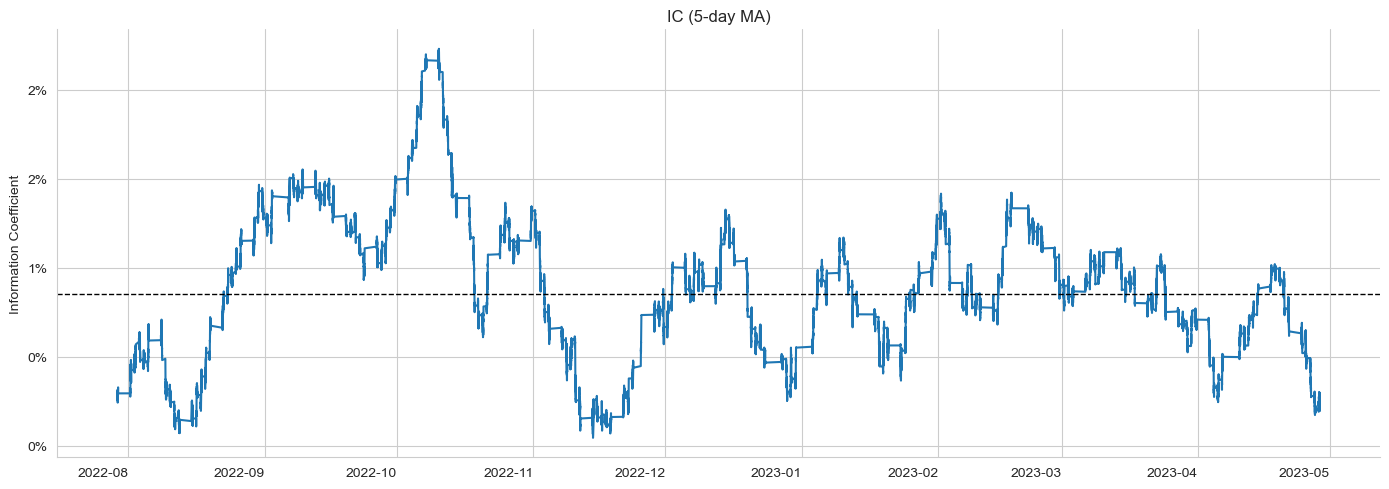

In [180]:
ax = ic_by_minute.rolling(5*650).mean().plot(figsize=(14, 5), title='IC (5-day MA)', rot=0)
ax.axhline(minute_ic_mean, ls='--', lw=1, c='k')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Information Coefficient')
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [181]:
by_minute = cv_predictions.groupby(minutes, group_keys=False)

In [182]:
cv_predictions

fwd1min          pred  quintile  decile
ticker date_time                                                    
AAPL   2022-07-19 09:31:00 -0.000169 -4.869255e-05         2       3
       2022-07-19 09:32:00 -0.001183  4.006088e-06         3       6
       2022-07-19 09:33:00  0.002165 -1.659723e-05         3       5
       2022-07-19 09:34:00 -0.000338  3.154574e-05         4       8
       2022-07-19 09:35:00 -0.002033  4.826320e-09         4       7
...                              ...           ...       ...     ...
ZS     2023-04-28 15:56:00  0.000891  2.172586e-05         5       9
       2023-04-28 15:57:00  0.000834  2.277291e-05         5       9
       2023-04-28 15:58:00  0.001047  2.135035e-05         5       9
       2023-04-28 15:59:00  0.000666  5.086760e-05         5      10
       2023-04-28 16:00:00 -0.000111  5.562111e-05         5      10

[7247209 rows x 4 columns]

In [183]:
by_minute

In [184]:
labels = list(range(1, 6))
cv_predictions['quintile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=5, labels=labels).astype(int))

In [ ]:
labels = list(range(1, 11))
cv_predictions['decile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=10, labels=labels).astype(int))

In [ ]:
cv_predictions.info(show_counts=True)

In [ ]:
def compute_intraday_returns_by_quantile(predictions, quantile='quintile'):
    by_quantile = cv_predictions.reset_index().groupby(['date_time', quantile])
    return by_quantile.fwd1min.mean().unstack(quantile).sort_index()

In [ ]:
intraday_returns = {'quintile': compute_intraday_returns_by_quantile(cv_predictions),
                    'decile': compute_intraday_returns_by_quantile(cv_predictions, quantile='decile')}

In [ ]:
def summarize_intraday_returns(returns):
    summary = returns.describe(deciles)
    return pd.concat([summary.iloc[:1].applymap(lambda x: f'{x:,.0f}'),
                      summary.iloc[1:].applymap(lambda x: f'{x:.4%}')])

In [ ]:
summary = summarize_intraday_returns(intraday_returns['quintile'])
summary

In [ ]:
summary = summarize_intraday_returns(intraday_returns['decile'])
summary

In [ ]:
def plot_cumulative_performance(returns, quantile='quintile', trading_costs_bp=0):
    """Plot average return by quantile (in bp) as well as cumulative return, 
        both net of trading costs (provided as basis points; 1bp = 0.01%) 
    """

    fig, axes = plt.subplots(figsize=(14, 4), ncols=2)

    sns.barplot(y='fwd1min', x=quantile,
                data=returns[quantile].mul(10000).sub(trading_costs_bp).stack().to_frame(
                    'fwd1min').reset_index(),
                ax=axes[0])
    axes[0].set_title(f'Avg. 1-min Return by Signal {quantile.capitalize()}')
    axes[0].set_ylabel('Return (bps)')
    axes[0].set_xlabel(quantile.capitalize())

    title = f'Cumulative Return by Signal {quantile.capitalize()}'
    (returns[quantile].sort_index().add(1).sub(trading_costs_bp/10000).cumprod().sub(1)
     .plot(ax=axes[1], title=title))

    axes[1].yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Return')
    fig.suptitle(f'Average and Cumulative Performance (Net of Trading Cost: {trading_costs_bp:.2f}bp)')

    sns.despine()
    fig.tight_layout()

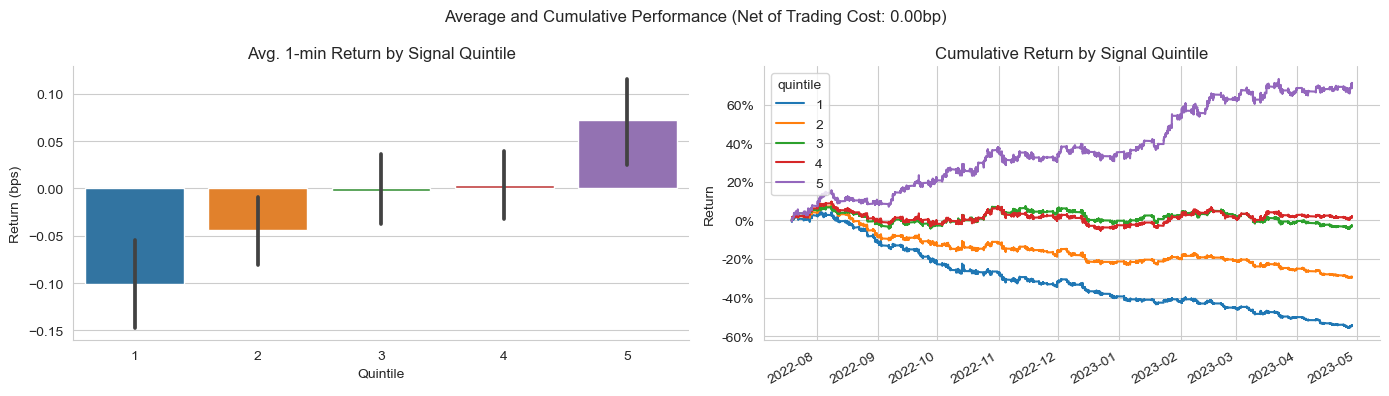

In [161]:
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=0)

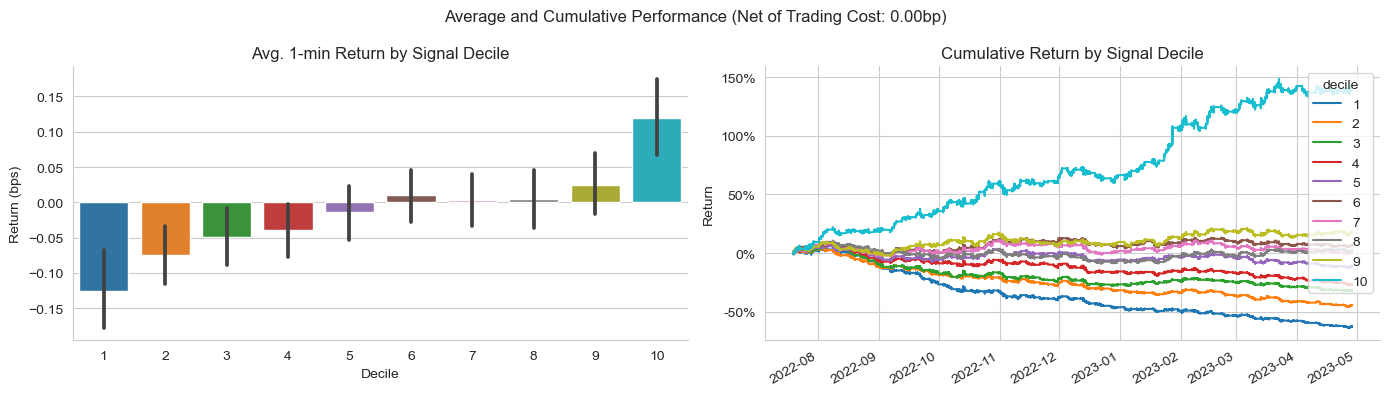

In [162]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=0)

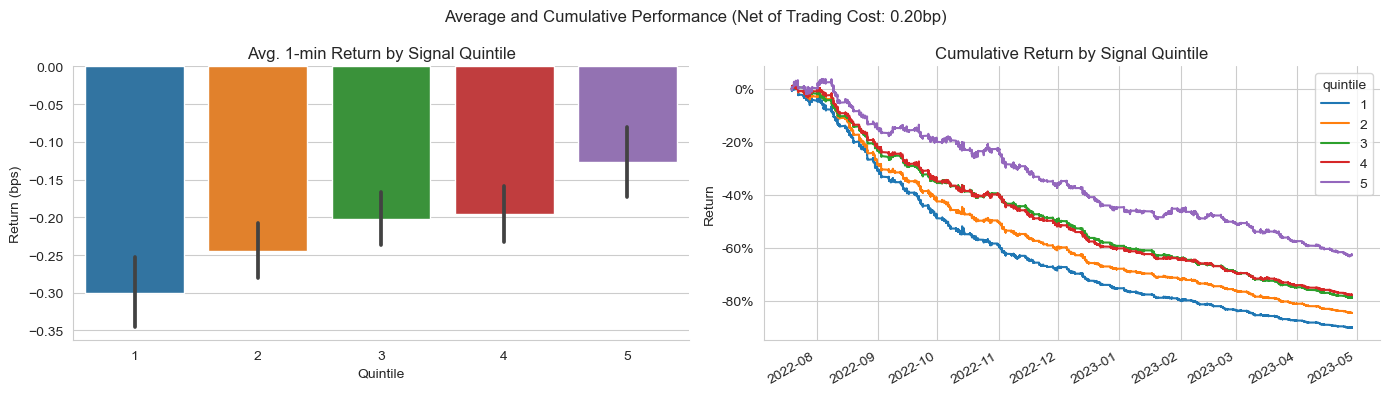

In [163]:
# assuming costs of a fraction of a basis point, close to the average return of the top quantile
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=.2)

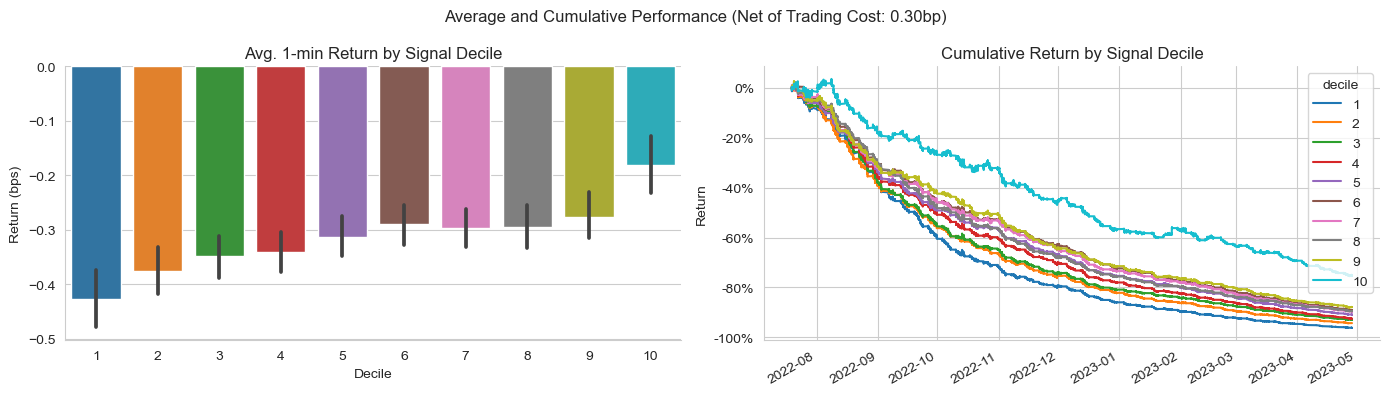

In [164]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=.3)

In [165]:
with pd.HDFStore(result_store) as store:
    fi_keys = [k[1:] for k in store.keys() if k[1:].startswith('fi')]
    fi = pd.concat([store[k].to_frame(i) for i, k in enumerate(fi_keys, 1)], axis=1)

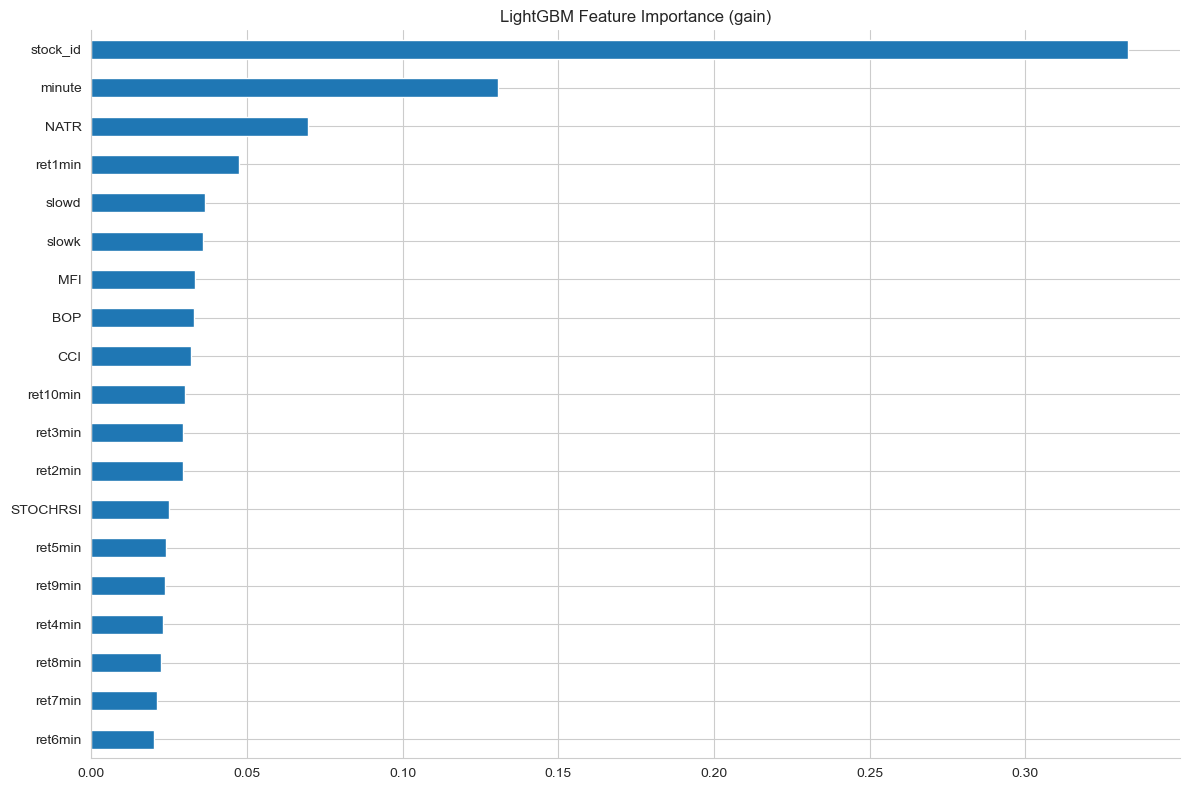

In [166]:
fi.mean(1).nsmallest(25).plot.barh(figsize=(12, 8), title='LightGBM Feature Importance (gain)')
sns.despine()
plt.tight_layout();